In [1]:
from src.data.data_loader import load_data
from src.data.data_cleaner import clean_data
from src.data.data_transforms import (
    create_time_diff_cols, create_cob_and_carb_availability_cols
)
import pandas as pd

In [3]:
df = create_time_diff_cols(clean_data(load_data()))

Index(['id', 'p_num', 'time', 'bg-0:00', 'insulin-0:00', 'carbs-0:00',
       'hr-0:00', 'steps-0:00', 'cals-0:00', 'activity-0:00', 'time_diff'],
      dtype='object')

In [5]:
from typing import List, Tuple

five_minute_patients: List[Tuple[str, pd.DataFrame]] = []
fifteen_minute_patients: List[Tuple[str, pd.DataFrame]] = []

df["time"] = pd.to_timedelta(df["time"])

patient_dfs = df.groupby("p_num")

for p_num, patient_df in patient_dfs:
    time_difference = patient_df.iloc[1]["time"] - patient_df.iloc[0]["time"]

    if time_difference == pd.Timedelta(minutes=5):
        five_minute_patients.append((p_num, patient_df))
    elif time_difference == pd.Timedelta(minutes=15):
        fifteen_minute_patients.append((p_num, patient_df))

In [6]:
five_minute_patients_with_cob_sim_cols = []
for p_num, patient_df in five_minute_patients:
    five_minute_patients_with_cob_sim_cols.append((p_num, create_cob_and_carb_availability_cols(patient_df)))

In [16]:
example_patient = five_minute_patients_with_cob_sim_cols[0][1]
print(example_patient["cob"])

8459      0.000000
8460      0.000000
8461      0.000000
8462      0.000000
8463      0.000000
           ...    
34326    11.151410
34327    10.136391
34328     9.205092
34329     8.351953
34330     7.571554
Name: cob, Length: 25872, dtype: float64


The goal of the **COB (Carbs on Board)** metric is to quantify how much of the meal's carbohydrate effect is still "in play"—that is, the amount of carbohydrate that has been ingested but not yet fully absorbed. This is crucial for forecasting future blood glucose levels.

$$\text{COB}(t) = c - \int_{t_{\text{meal}}}^{t} Q_2(z)\,dz$$

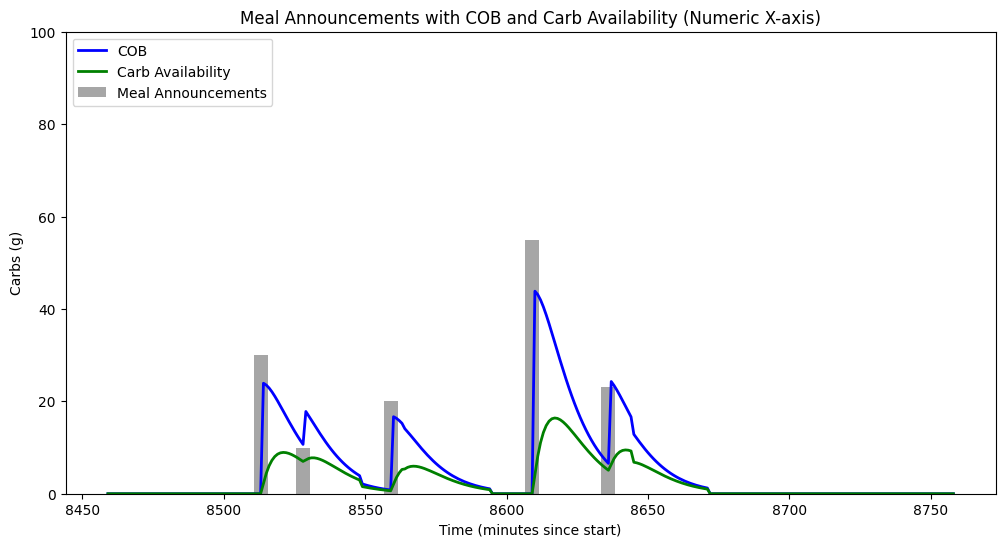

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the "time" column to minutes (numeric)

example_patient_subset = example_patient.iloc[:300]  # Get first 500 rows

x_index = example_patient_subset.index 

plt.figure(figsize=(12, 6))

# Plot the meal announcements as a bar chart.
plt.bar(
    x_index, 
    example_patient_subset["carbs-0:00"],
    width=5,         # Each bar spans 5 minutes
    color='gray',
    alpha=0.7,
    label="Meal Announcements"
)

# Overlay the COB (Carbs on Board) curve.
plt.plot(
    x_index, 
    example_patient_subset["cob"],
    label="COB",
    color="blue",
    linewidth=2
)

# Overlay the carb availability curve.
plt.plot(
    x_index, 
    example_patient_subset["carb_availability"],
    label="Carb Availability",
    color="green",
    linewidth=2
)

plt.ylim(0, 100)
plt.xlabel("Time (minutes since start)")
plt.ylabel("Carbs (g)")
plt.title("Meal Announcements with COB and Carb Availability (Numeric X-axis)")
plt.legend()
plt.show()
